In [23]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from nltk.tokenize.casual import casual_tokenize 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings("ignore")

# Step 1: Get Data

The goal of this exercise is to compare classification scores using different sources of input data, and then across multiple classifiers. 

First, I want to compare LDA classification comparing different input sources:
- bag_of_words count vectors
- tf-idf vectors
- topic vectors

Second, I want to compare multiple classifiers against each of those vectors. For classification, I will use:
- LDA: https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html
- Gaussian Naive Bayes: https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html
- Logistic Regression: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- K Nearest Neighbors: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
- Linear SVC: https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

That said, the first step of this is building the training dataframe.

In [24]:
src_dir = r'C:\Users\groov\PythonCode\output\trump_tweets\\'
hostile_file = src_dir + 'trump_tweets_hostile_clf.csv'

clf_df = pd.read_csv(hostile_file, header=None)
clf_df.columns = ['ts', 'tweet', 'label']
clf_df.drop('ts', axis=1, inplace=True)
clf_df.reset_index(drop=True, inplace=True)

# wrangling
clf_df['tweet'] = clf_df['tweet'].str.replace('&amp;', 'and')

clf_df.head()

,tweet,label
0,no matter what you do for the do nothing democ...,1
1,"them happy, or even a little bit satisfied. th...",1
2,the most often used phrase in the lamestream m...,1
3,just like i was right on ventilators (our coun...,0
4,.@foxnews “dems say president trump is trying ...,0


To maximize accuracy, we are not going to remove stopwords. Let's also set aside the data for tfidf and bow.

In [25]:
tweets = clf_df['tweet']
labels = clf_df['label']

del(clf_df)

# Step 2: Bag of Words

In [26]:
counter = CountVectorizer(tokenizer=casual_tokenize, ngram_range=(1,3))
bow_docs = counter.fit_transform(tweets.values)
bow_docs

<1432x76162 sparse matrix of type '<class 'numpy.int64'>'
	with 162694 stored elements in Compressed Sparse Row format>

# Step 2: TF-IDF Vectorize

Next, I'm going to use the cleaned up text and create tf-idf vectors for tokens, bigrams, and trigrams. I'll confirm this still looks good by doing basic tf-idf analysis by label. I am not going to remove stopwords, as they often contain information. For
instance, one common slur is "do nothing democrats", and the word "do" is a stopword. 

In [5]:
tfidf = TfidfVectorizer(tokenizer=casual_tokenize, ngram_range=(1,3), lowercase=True, sublinear_tf=True)
tfidf_docs = tfidf.fit_transform(raw_documents=tweets)
tfidf_docs

<1432x76162 sparse matrix of type '<class 'numpy.float64'>'
	with 162694 stored elements in Compressed Sparse Row format>

# Topic Modeling with TruncatedSVD

In [6]:
svd = TruncatedSVD(n_components=100, n_iter=100, random_state=1337)
svd_topic_vectors = svd.fit_transform(tfidf_docs)

You can't get much visibility into TruncatedSVD without using something like Lime. I'm not going to worry about it
for this exercise.

# Classification

First, I want to try classification using bag of words count vectors as our X input data.

In [7]:
X = bow_docs
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1337, test_size=0.5)
X_train.shape, X_test.shape, len(y_train), len(y_test)

((716, 76162), (716, 76162), 716, 716)

In [ ]:
lda = LDA(n_components=1, solver='lsqr', shrinkage=0.4)
lda.fit(X_train.toarray(), y_train)
lda.score(X_train.toarray(), y_train), lda.score(X_test.toarray(), y_test)

Result: Utter Failure

MemoryError: Unable to allocate 43.2 GiB for an array with shape (76162, 76162) and data type float64

The takeaway is that if you want to use count vectors as input, you're going to need a lot of memory even for tiny data.

The alternative is to remove stopwords, but then you potentially reduce accuracy. Maybe this is part of the reason people are
teaching to throw away stop words or to use neural networks for everything. 

Let's try with Naive Bayes to see if it runs into the same memory problems.

In [8]:
nb = GaussianNB()
nb.fit(X_train.toarray(), y_train)
nb.score(X_train.toarray(), y_train), nb.score(X_test.toarray(), y_test)

(0.994413407821229, 0.8184357541899442)

Naive Bayes works, but it massively overfits. This is expected when you have 76,000 features.

Next, let's try tf-idf topic vectors. I expect the same results, as we are dealing with the same n-grams. Values are just calculated rather than counted.

In [9]:
X = tfidf_docs
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1337, test_size=0.5)
X_train.shape, X_test.shape, len(y_train), len(y_test)

((716, 76162), (716, 76162), 716, 716)

In [ ]:
lda = LDA(n_components=1, solver='lsqr', shrinkage=0.4)
lda.fit(X_train.toarray(), y_train)
lda.score(X_train.toarray(), y_train), lda.score(X_test.toarray(), y_test)

Result: Utter Failure

MemoryError: Unable to allocate 43.2 GiB for an array with shape (76162, 76162) and data type float64

Same result for tf-idf. Let's try with Naive Bayes to see if it runs into the same memory problems.

In [10]:
nb = GaussianNB()
nb.fit(X_train.toarray(), y_train)
nb.score(X_train.toarray(), y_train), nb.score(X_test.toarray(), y_test)

(0.994413407821229, 0.8114525139664804)

Again, this massively overfits, and the accuracy is even worse than with count vectors, which is unexpected.

Finally, let's try with topic vectors.

In [11]:
X = svd_topic_vectors
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1337, test_size=0.5)
X_train.shape, X_test.shape, len(y_train), len(y_test)

((716, 100), (716, 100), 716, 716)

This time, rather than having 76,000 features, we have 100. This should reduce overfitting and should open the door for use of other classifiers as well. Let's see how performance is this time.

In [12]:
lda = LDA(n_components=1, solver='lsqr', shrinkage=0.4)
lda.fit(X_train, y_train)
lda.score(X_train, y_train), lda.score(X_test, y_test)

(0.909217877094972, 0.8952513966480447)

This is a great fit. There's no overfitting, and LDA successfully runs. We also didn't need to throw away stop words,
and the classifier trains and scores in a fraction of a second. This is beautiful.

So, here's the takeaway. If you're going to use raw count vectors or tfidf vectors, you can use them in Naive Bayes, but you are going to create a model that massively overfits, and if you attempt to use them with LDA, it'll not run at all. So, your choices are a) massive overfitting or b) utter failure unless you run this on a sever with obnoxiously unnecessary specs.

If you use topics on the other hand, you eliminate overfitting due to massive feature reduction, and accuracy can drastically improve. So, this is win-win.

So, for the rest of this experiment, we are going to disregard the raw count and tfidf vectors and use topic vectors for our X.

# Classifier Comparisons 

Important note: I am doing this experiment off of a few different models that I have successfully used in the past. This is not a definitive list of classifiers. If you would like me to run a classifier that I haven't tried, let me know and I'll see if I can get it added. That said, I am completely avoiding neural networks for this experiment. This is a comparison of simpler models.

First things first, let's set up our input data.

In [13]:
X = svd_topic_vectors
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1337, test_size=0.5)
X_train.shape, X_test.shape, len(y_train), len(y_test)

((716, 100), (716, 100), 716, 716)

Let's also keep these values in an array so that we can visualize this at the end.

In [14]:
model = []
train_score = []
test_score = []

My maximum score for this dataset has thus far come from using LDA, so, let's run that first.

In [15]:
lda = LDA(n_components=1, solver='lsqr', shrinkage=0.4)
lda.fit(X_train, y_train)

train = lda.score(X_train, y_train)
test = lda.score(X_test, y_test)

model.append('LDA')
train_score.append(train)
test_score.append(test)

train, test

(0.909217877094972, 0.8952513966480447)

In [16]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=1337, n_jobs=-1, C=13.04)
lr.fit(X_train, y_train)

train = lr.score(X_train, y_train)
test = lr.score(X_test, y_test)

model.append('Logistic Regression')
train_score.append(train)
test_score.append(test)

train, test

(0.9064245810055865, 0.8896648044692738)

In [17]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(X_train, y_train)

train = knn.score(X_train, y_train)
test = knn.score(X_test, y_test)

model.append('KNN')
train_score.append(train)
test_score.append(test)

train, test

(0.8282122905027933, 0.8282122905027933)

In [18]:
nb = GaussianNB()
nb.fit(X_train, y_train)

train = nb.score(X_train, y_train)
test = nb.score(X_test, y_test)

model.append('Gaussian Naive Bayes')
train_score.append(train)
test_score.append(test)

train, test

(0.6983240223463687, 0.6731843575418994)

Oh wow, that is terrible. That's even worse than the overfitting models using count and tfidf vectors. This is good to know!

In [19]:
from sklearn.svm import LinearSVC

svc = LinearSVC(C=1.9, random_state=1337)
svc.fit(X_train, y_train)

train = svc.score(X_train, y_train)
test = svc.score(X_test, y_test)

model.append('Linear SVC')
train_score.append(train)
test_score.append(test)

train, test

(0.9134078212290503, 0.8952513966480447)

And now let's put it all together.

In [20]:
result_df = pd.DataFrame({'model':model, 'train_score':train_score, 'test_score':test_score})
result_df.sort_values('model', inplace=True)
result_df.set_index('model', inplace=True)
round(result_df * 100,2)

,train_score,test_score
model,,
Gaussian Naive Bayes,69.83,67.32
KNN,82.82,82.82
LDA,90.92,89.53
Linear SVC,91.34,89.53
Logistic Regression,90.64,88.97


So, this is interesting. I did not expect Linear SVC to do so well. Linear SVC and LDA both tied for first place, with Logistic Regression half a percent behind. Gaussian Naive Bayes, which is often taught as a fundamental NLP model scored the absolute worst when using topics, and KNN predicted at about 82%.

An additional option is to create a voting classifier using the predictions of each of these, but to be honest, everytime I have done this, I just end up with an over-engineered piece of software that is much more pain to maintain than it is worth.

Anyway, the moral of this story is to try different models. There is no free lunch.

In [21]:
# # Logistic Regression Tuning

# train = []
# test = []
# cval = []

# for C in np.arange(0.1, 20.1, 0.01):
#     C = round(C, 3)
#     lr = LogisticRegression(random_state=1337, n_jobs=-1, C=C)
#     lr.fit(X_train, y_train)
#     train_score = lr.score(X_train, y_train)
#     test_score = lr.score(X_test, y_test)
#     train.append(train_score)
#     test.append(test_score)
#     cval.append(C)
#     print('{}: {} {}'.format(C, round(train_score, 5), round(test_score, 5)))

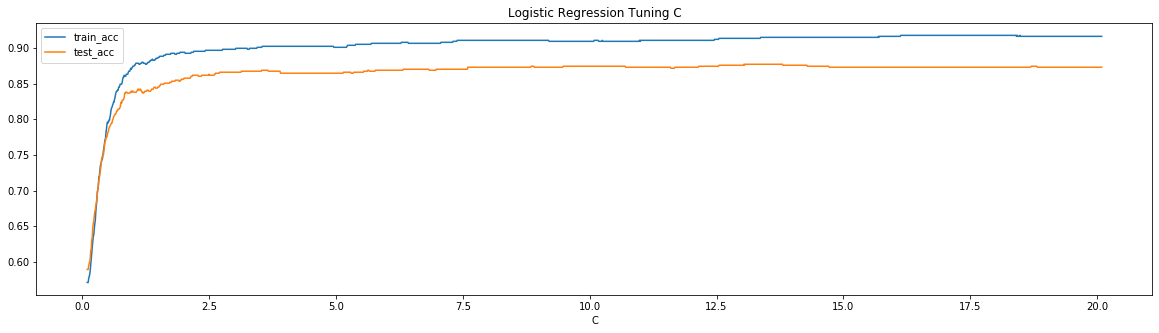

In [95]:
tune_df = pd.DataFrame({'C':cval, 'train_acc':train, 'test_acc':test})
tune_df.set_index('C', inplace=True)
tune_df.sort_index(inplace=True)
_= tune_df.plot(figsize=(20,5), title='Logistic Regression Tuning C')

In [103]:
best_df = tune_df[tune_df['test_acc'] == tune_df['test_acc'].max()]
best_df.iloc[0:1]

,train_acc,test_acc
C,,
13.04,0.913408,0.877095


In [22]:
# # Linear SVC Tuning

# train = []
# test = []
# cval = []

# for C in np.arange(0.1, 20.1, 0.01):
#     C = round(C, 3)
#     svc = LinearSVC(C=C, random_state=1337)
#     svc.fit(X_train, y_train)
#     train_score = svc.score(X_train, y_train)
#     test_score = svc.score(X_test, y_test)
#     train.append(train_score)
#     test.append(test_score)
#     cval.append(C)
#     print('{}: {} {}'.format(C, round(train_score, 5), round(test_score, 5)))

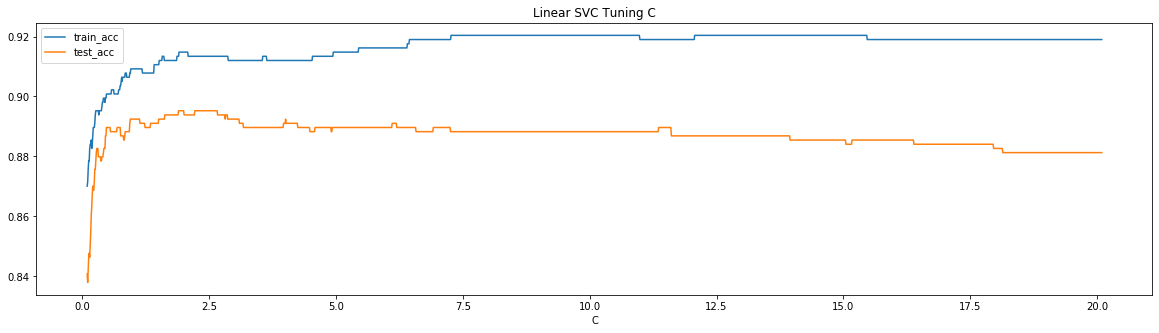

In [121]:
tune_df = pd.DataFrame({'C':cval, 'train_acc':train, 'test_acc':test})
tune_df.set_index('C', inplace=True)
tune_df.sort_index(inplace=True)
_= tune_df.plot(figsize=(20,5), title='Linear SVC Tuning C')

In [122]:
best_df = tune_df[tune_df['test_acc'] == tune_df['test_acc'].max()]
best_df.iloc[0:1]

,train_acc,test_acc
C,,
1.9,0.913408,0.895251
